# Starbucks Capstone Challenge - Exploratory Data Analysis

## Introduction

As we now have a new perspective with the data. We'll look closer trying to answer our questions presented at the beginning.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sb_capstone.wrangling import (
    clean_transcript_group,
    tukey_rule
)

%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,received,viewed,completed,amount,reward,non_offer_amount,mapped_offer,offer_type,...,web,email,mobile,social,gender,age,income,membership_year,membership_month,membership_day
0,1,2,True,True,False,0.00,0.0,0.00,10,discount,...,True,True,True,False,U,NaN,NaN,2017,2,12
1,2,2,False,False,False,0.00,0.0,0.00,0,no_offer,...,False,False,False,False,F,55.0,112000.0,2017,7,15
2,3,2,True,True,False,0.00,0.0,0.00,4,bogo,...,True,True,True,False,U,NaN,NaN,2018,7,12
3,4,2,True,True,True,19.67,0.0,29.72,8,informational,...,False,True,True,True,F,75.0,100000.0,2017,5,9
4,5,2,False,False,False,0.00,0.0,3.50,0,no_offer,...,False,False,False,False,U,NaN,NaN,2017,8,4


In [4]:
transcript_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                102000 non-null  int64   
 1   wave              102000 non-null  int64   
 2   received          102000 non-null  bool    
 3   viewed            102000 non-null  bool    
 4   completed         102000 non-null  bool    
 5   amount            102000 non-null  float64 
 6   reward            102000 non-null  float64 
 7   non_offer_amount  102000 non-null  float64 
 8   mapped_offer      102000 non-null  category
 9   offer_type        102000 non-null  category
 10  difficulty        102000 non-null  float64 
 11  duration          102000 non-null  float64 
 12  web               102000 non-null  bool    
 13  email             102000 non-null  bool    
 14  mobile            102000 non-null  bool    
 15  social            102000 non-null  bool    
 16  ge

AB TESTING NOTES

* State Context (goal of having promotions)
* State potential disadvantages
* Pre-requisites
   * Choose Key Metrics
   * Generalize metrics is only fair when N_control = N_treatment
   * If not, per customer metrics, normalization
      * Revenue per user
   * Randomization Units
      * Users, assume there's enough
* Experimentation
   * Target all users/specific users
   * Understand the journey
   * Select a population (choose which stage in the journey you wish to study)
   * Sample size
      * (16 * sigma^2) / delta^2
      * sigma - STD of the population
      * delta - difference between treatment and control
   * Practical significance boundary
      * How many revenue increase per user to outweigh the cost
   * Determine
      * Power of the test: 80%
      * Significance Level: 5%
   * How Long
      * Ramp-up plan
      * Day of week effect (if there are special days, run/round a whole week)
      * Seasonality (should not used for analysis)
      * Primacy and novelty effects
      * Better than overpowered, account for unique users
      * Running experiment too long diminishing return
   * Results to Decision
      * Number of users assigned groups is truly random
      * Statistically and Practically significant
         * If one of them fails, it's not conclusive, run test with more power

https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing
https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
https://github.com/mnguyenngo/ab-framework/blob/master/src/stats.py


For promotions and offers, it's not about giving stuff free, but attracting to buy without having the initial intentions. Therefore, revenue is the total amount, offer and non-offer minus the given discounts. Since we don't have a balance control and treatment, we'll get the mean revenue per customer.

## Q1: Which offer yields the best results?

### Metrics

**Invariant Metrics**

Group sizes

https://www.markhw.com/blog/control-size

Length of test

Primacy and novelty

In [5]:
transcript_group.mapped_offer.value_counts()

0     25723
4      7677
5      7668
1      7658
6      7646
10     7632
8      7618
3      7617
7      7597
2      7593
9      7571
Name: mapped_offer, dtype: int64

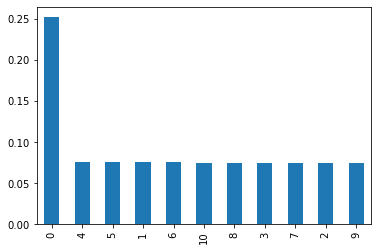

In [6]:
transcript_group.mapped_offer.value_counts(normalize=True).plot(kind='bar');

**Metrics**

Incremental Response Rate

Purchased if:

* Received, viewed, completed = True
* Received = False
* Received, viewed = False
* Received, completed = False

Legend:
* purch_treat = Number of customers who successfully purchased based on offer
* cust_treat = Number of customers who received the offer
* purch_ctrl = Number of customers who successfully purchased not affected by offer
* cust_ctrl = Number of customers who did not received the offer

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

Incremental Profit

Profit difference made from a managerial decision.

3 factors, amount from offers, rewards given, amount from non-offers, and cost of promotions

Assuming that each channel promotions costs 0.15.

$$ profit = amount_{offers} - reward - (email * 0.15 + web * 0.15 + mobile * 0.15 + social * 0.15) - amount_{non-offers} $$


In [7]:
transcript_group["purchased"] = \
    ((transcript_group.received) & (transcript_group.viewed & transcript_group.completed)) | \
    ((~transcript_group.received) & (transcript_group.non_offer_amount > 0))

In [8]:
transcript_group.head()

,id,wave,received,viewed,completed,amount,reward,non_offer_amount,mapped_offer,offer_type,...,email,mobile,social,gender,age,income,membership_year,membership_month,membership_day,purchased
0,1,2,True,True,False,0.00,0.0,0.00,10,discount,...,True,True,False,U,NaN,NaN,2017,2,12,False
1,2,2,False,False,False,0.00,0.0,0.00,0,no_offer,...,False,False,False,F,55.0,112000.0,2017,7,15,False
2,3,2,True,True,False,0.00,0.0,0.00,4,bogo,...,True,True,False,U,NaN,NaN,2018,7,12,False
3,4,2,True,True,True,19.67,0.0,29.72,8,informational,...,True,True,True,F,75.0,100000.0,2017,5,9,True
4,5,2,False,False,False,0.00,0.0,3.50,0,no_offer,...,False,False,False,U,NaN,NaN,2017,8,4,True


### Practical

In [9]:
def get_irr(data, offers=np.arange(11)):

    purch_treat = data[data.received & data.mapped_offer.isin(offers)].purchased.sum()
    cust_treat = len(data[data.received & data.mapped_offer.isin(offers)])

    purch_ctrl = data[~data.received].purchased.sum()
    cust_ctrl = len(data[~data.received])

    irr = (purch_treat / cust_treat) - (purch_ctrl / cust_ctrl)

    return irr


In [10]:
irr = get_irr(transcript_group)

print(f"IRR: {irr}")

IRR: -0.1055434871167969


In [11]:
for i in range(1,11):
    irr = get_irr(transcript_group, [i])

    print(f"IRR {i}: {irr}")

IRR 1: -0.13479241196008662
IRR 2: -0.1109132373261395
IRR 3: -0.24991971325411924
IRR 4: -0.20129270130972365
IRR 5: -0.30712326892801645
IRR 6: 0.09632446136924949
IRR 7: 0.1358330149852241
IRR 8: -0.07116258196266673
IRR 9: -0.008010322711407447
IRR 10: -0.20149500247394614


In [12]:
transcript_group.loc[transcript_group.received, "revenue"] = transcript_group.amount + transcript_group.non_offer_amount - transcript_group.reward - (transcript_group.email * 0.15 + transcript_group.mobile * 0.15 + transcript_group.social * 0.15 + transcript_group.web * 0.15)
transcript_group.loc[~transcript_group.received, "revenue"] = transcript_group.non_offer_amount

In [13]:
def get_revenue_rate(data, offers=np.arange(11)):
    revenue_treat = transcript_group[transcript_group.received & transcript_group.mapped_offer.isin(offers)].revenue.mean()
    revenue_ctrl = transcript_group[~transcript_group.received].revenue.mean()

    ip = revenue_treat - revenue_ctrl

    return ip

In [14]:
ip = get_revenue_rate(transcript_group)
print(f"IP : {ip}")

IP : 7.1784033236621685


In [15]:
for i in range(1, 11):
    ip = get_revenue_rate(transcript_group, [i])

    print(f"IP {i}: {ip}")

IP 1: 7.23392715709535
IP 2: 6.257871047662954
IP 3: 4.381981396912231
IP 4: 4.2808572214020675
IP 5: 3.955309807046355
IP 6: 10.958675183277832
IP 7: 14.67824528596339
IP 8: 5.6624164404595625
IP 9: 7.942245372581548
IP 10: 6.485186641429111


### Practical

In [16]:
transcript_group.shape

(102000, 24)

In [57]:
class ABTest():

    def __init__(self, data, col, conv):
        self.data = data

        self.data_ctrl = data[~data[col]]
        self.data_treat = data[data[col]]

        self.n_ctrl, self.n_treat = len(self.data_ctrl), len(self.data_treat)

        self.c_ctrl, self.c_treat = conv(self.data_ctrl), conv(self.data_treat)

        self.p_ctrl = self.c_ctrl / self.n_ctrl
        self.p_treat = self.c_treat / self.n_treat

    def calculate_practical(self):
        return self.p_treat - self.p_ctrl

    def calculate_statistical(self):
        p_null = (self.c_ctrl + self.c_treat) / (self.n_ctrl + self.n_treat)
        se_p = np.sqrt(p_null * (1 - p_null) * (1 / self.n_ctrl + 1 / self.n_treat))

        z_score = (self.p_treat - self.p_ctrl) / se_p
        p_value = 1 - stats.norm.cdf(z_score)

        return se_p, z_score, p_value

In [63]:
ab = ABTest(transcript_group, "received", lambda x: x.purchased.sum())
ab.calculate_practical(), ab.calculate_statistical()

(-0.1055434871167969, (0.0035309910613440043, -29.890612942142024, 1.0))

In [66]:
for i in np.arange(1, 11):
    data = transcript_group[(transcript_group.mapped_offer == i) | (~transcript_group.received)]
    test = ABTest(data, "received", lambda x: x.purchased.sum())
    print(f"Offer {i}: {test.calculate_practical()} : {test.calculate_statistical()}")

Offer 1: -0.13479241196008662 : (0.006472370403367817, -20.825818604254952, 1.0)
Offer 2: -0.1109132373261395 : (0.006501094073535643, -17.060703332634432, 1.0)
Offer 3: -0.24991971325411924 : (0.006440354154244457, -38.80527487598052, 1.0)
Offer 4: -0.20129270130972365 : (0.006441867206608812, -31.247570751414177, 1.0)
Offer 5: -0.30712326892801645 : (0.006393396398164098, -48.03757655574253, 1.0)
Offer 6: 0.09632446136924949 : (0.006512738204663402, 14.790163268082388, 0.0)
Offer 7: 0.1358330149852241 : (0.006527836419434252, 20.808274940963724, 0.0)
Offer 8: -0.07116258196266673 : (0.006502930049393966, -10.943156611272276, 1.0)
Offer 9: -0.008010322711407447 : (0.006530192402562932, -1.2266595251104089, 0.8900247068364098)
Offer 10: -0.20149500247394614 : (0.006456768639749953, -31.206786818018816, 1.0)


We fail to reject the hypothesis. Therefore, the conversion rate is did not improve our conversion rate.

## Q2: Which demographic more likely more influenced by offers? 

## Q3: Which type of offer best to a certain demographics?